In [1]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file_id = '1-8s2kHYlyy8jLBy12s3bNDUEh20dfxdd'
downloaded = drive.CreateFile({'id':file_id})
downloaded.FetchMetadata(fetch_all=True)
downloaded.GetContentFile(downloaded.metadata['title'])
!unzip data.zip && rm data.zip

Archive:  data.zip
   creating: data/
   creating: data/asl_data/
  inflating: data/asl_data/sign_mnist_train.csv  
  inflating: data/asl_data/sign_mnist_valid.csv  
   creating: data/asl_images/
  inflating: data/asl_images/a.png   
  inflating: data/asl_images/b.png   


In [2]:
import tensorflow.keras as keras
import pandas as pd

# Load in our data from CSV files
train_df = pd.read_csv("data/asl_data/sign_mnist_train.csv")
valid_df = pd.read_csv("data/asl_data/sign_mnist_valid.csv")

# Separate out our target values
y_train = train_df['label']
y_valid = valid_df['label']
del train_df['label']
del valid_df['label']

# Separate our our image vectors
x_train = train_df.values
x_valid = valid_df.values

# Turn our scalar targets into binary categories
num_classes = 24
y_train = keras.utils.to_categorical(y_train, num_classes)
y_valid = keras.utils.to_categorical(y_valid, num_classes)

# Normalize our image data
x_train = x_train / 255
x_valid = x_valid / 255

# Reshape the image data for the convolutional network
x_train = x_train.reshape(-1,28,28,1)
x_valid = x_valid.reshape(-1,28,28,1)

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    MaxPool2D,
    Flatten,
    Dropout,
    BatchNormalization,
)

model = Sequential()
model.add(Conv2D(75, (3, 3), strides=1, padding="same", activation="relu", 
                 input_shape=(28, 28, 1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(50, (3, 3), strides=1, padding="same", activation="relu"))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(25, (3, 3), strides=1, padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Flatten())
model.add(Dense(units=512, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(units=num_classes, activation="softmax"))

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range=0.1,  # Randomly zoom image
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images horizontally
    vertical_flip=False, # Don't randomly flip images vertically
)  

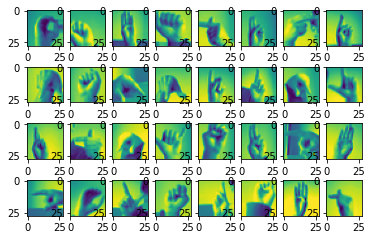

In [5]:
import matplotlib.pyplot as plt
import numpy as np
batch_size = 32
img_iter = datagen.flow(x_train, y_train, batch_size=batch_size)

x, y = img_iter.next()
fig, ax = plt.subplots(nrows=4, ncols=8)
for i in range(batch_size):
    image = x[i]
    ax.flatten()[i].imshow(np.squeeze(image))
plt.show()

In [6]:
datagen.fit(x_train)

In [18]:
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [19]:
model.fit(img_iter,
          epochs=5,
          steps_per_epoch=len(x_train)/batch_size, 
          validation_data=(x_valid, y_valid))

Epoch 1/5
857/857 [==============================] - 20s 22ms/step - loss: 0.0932 - accuracy: 0.9704 - val_loss: 0.1084 - val_accuracy: 0.9631
Epoch 2/5
857/857 [==============================] - 19s 22ms/step - loss: 0.0763 - accuracy: 0.9756 - val_loss: 0.1467 - val_accuracy: 0.9547
Epoch 3/5
857/857 [==============================] - 19s 22ms/step - loss: 0.0768 - accuracy: 0.9759 - val_loss: 0.0490 - val_accuracy: 0.9830
Epoch 4/5
857/857 [==============================] - 19s 22ms/step - loss: 0.0621 - accuracy: 0.9797 - val_loss: 0.0212 - val_accuracy: 0.9915
Epoch 5/5
857/857 [==============================] - 19s 22ms/step - loss: 0.0659 - accuracy: 0.9787 - val_loss: 0.0239 - val_accuracy: 0.9907


In [20]:
model.save('asl_model')

INFO:tensorflow:Assets written to: asl_model/assets


In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 75)        750       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 75)       300       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 75)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 50)        33800     
                                                                 
 dropout (Dropout)           (None, 14, 14, 50)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 50)       2

In [22]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_image(image_path):
    image = mpimg.imread(image_path)
    plt.imshow(image, cmap='gray')

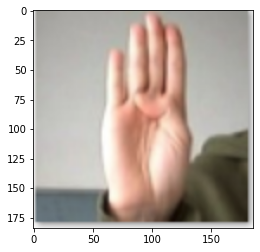

In [23]:
show_image('data/asl_images/b.png')

In [24]:
from tensorflow.keras.preprocessing import image as image_utils

def load_and_scale_image(image_path):
    image = image_utils.load_img(image_path, color_mode="grayscale", target_size=(28,28))
    return image

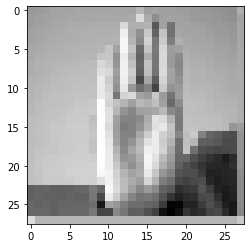

In [25]:
image = load_and_scale_image('data/asl_images/b.png')
plt.imshow(image, cmap='gray')

In [26]:
image = image_utils.img_to_array(image)

In [27]:
# This reshape corresponds to 1 image of 28x28 pixels with one color channel
image = image.reshape(1,28,28,1) 

In [28]:
image = image / 255

In [29]:
prediction = model.predict(image)
print(prediction)

[[5.6281850e-15 1.0000000e+00 1.4678608e-19 9.4828002e-18 4.4578353e-15
  1.1246729e-12 1.6229812e-22 3.9437460e-23 6.6590966e-13 4.5961649e-16
  1.4499375e-16 3.4344803e-19 4.9320538e-17 5.8867546e-23 6.0641008e-17
  1.4936853e-20 3.4393032e-20 6.0071989e-20 1.0503681e-23 3.4257634e-13
  5.0094640e-21 2.1703101e-11 6.8284733e-14 4.5440404e-23]]


In [30]:
import numpy as np
np.argmax(prediction)
# Alphabet does not contain j or z because they require movement
alphabet = "abcdefghiklmnopqrstuvwxy"
dictionary = {}
for i in range(24):
    dictionary[i] = alphabet[i]
dictionary
dictionary[np.argmax(prediction)]


'b'

In [31]:
def predict_letter(file_path):
    show_image(file_path)
    image = load_and_scale_image(file_path)
    image = image_utils.img_to_array(image)
    image = image.reshape(1,28,28,1) 
    image = image/255
    prediction = model.predict(image)
    # convert prediction to letter
    predicted_letter = dictionary[np.argmax(prediction)]
    return predicted_letter

'b'

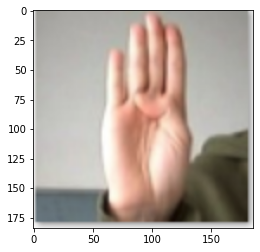

In [32]:
predict_letter("data/asl_images/b.png")

'a'

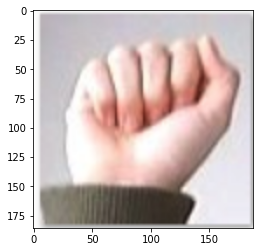

In [33]:
predict_letter("data/asl_images/a.png")